In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn import model_selection
from IPython.display import display, HTML
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
from stellargraph import datasets
import networkx as nx
from stellargraph.data import BiasedRandomWalk
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import warnings
warnings.filterwarnings("ignore")

In [2]:
LIMIT = 250

In [3]:
bitcoin_address =  pd.read_csv('bitcoin_address.csv',nrows=LIMIT)

bitcoin_address_link =  pd.read_csv('bitcoin_address_link.csv',nrows=LIMIT)

page =  pd.read_csv('page.csv',nrows=LIMIT)

page_link =  pd.read_csv('page_link.csv',nrows=LIMIT)

domain =  pd.read_csv('domain.csv',nrows=LIMIT)

In [4]:
G1 = nx.Graph()
node_subjects = {}

#insert bitcoin address nodes

for index, row in tqdm(bitcoin_address.iterrows()):
    G1.add_node(row.id)
    node_subjects[row.id]='b'
    
#insert pages

for index, row in tqdm(page.iterrows()):
    G1.add_node(row.id)
    node_subjects[row.id]='p'
    
#insert page - bitcoin addres edges

for index, row in tqdm(bitcoin_address_link.iterrows()):
    G1.add_edge(row.bitcoin_address, row.page)
    
#insert page - page edges

for index, row in tqdm(page_link.iterrows()):
    G1.add_edge(row.link_from, row.link_to )
    
    
#insert domain

for index, row in tqdm(domain.iterrows()):
    G1.add_node(row.id)
    node_subjects[row.id]='d'
    
#insert page - domain edges

for index, row in tqdm(page.iterrows()):
    G1.add_edge(row.id, row.domain )


In [5]:
g1 =  StellarGraph.from_networkx(G1)
print(g1.info())

StellarGraph: Undirected multigraph
 Nodes: 1055, Edges: 733

 Node types:
  default: [1055]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [733]
        Weights: all 1 (default)
        Features: none


In [6]:
#Corpus generation using random walks

rw = BiasedRandomWalk(g1)

walks = rw.run(
    nodes=list(g1.nodes()),  
    length=100, 
    n=10,  # number of random walks per root node
    p=0.5,  
    q=2.0, 
)
print("Total Random walks: {}".format(len(walks)))

Total Random walks: 10550


In [7]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [8]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word
node_embeddings = (model.wv.vectors)
temp = [int(node_id) for node_id in node_ids]
node_targets = [node_subjects.get(i) for i in temp]
node_targets = list(filter(lambda x:x!=None,node_targets))

In [9]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

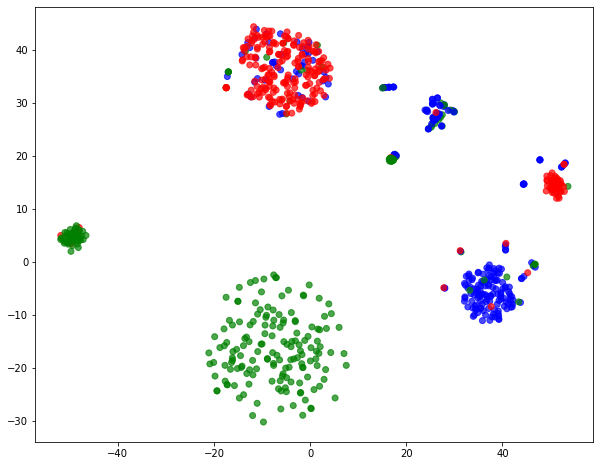

In [10]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

colors = np.array(["red", "green","blue", "yellow",'orange'])

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0][:len(node_targets)],
    node_embeddings_2d[:, 1][:len(node_targets)],
    c=colors[node_colours],
    cmap="jet",alpha=alpha,)

plt.show()

In [11]:
#Downstream task
X = node_embeddings[:len(node_targets)]
y = np.array(node_targets)

In [12]:
len(X)

750

In [13]:
len(y)

750

In [14]:
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

In [15]:
pd.DataFrame({
    'Shapes':["X_train","y_train" ,"X_test", "y_test"],
       "Values":[ X_train.shape, y_train.shape, X_test.shape, y_test.shape]
        }
)

,Shapes,Values
0,X_train,"(75, 128)"
1,y_train,"(75,)"
2,X_test,"(675, 128)"
3,y_test,"(675,)"


In [16]:
modelLGR = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
modelLGR.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [17]:
y_pred = modelLGR.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.8474074074074074


In [18]:
print('LogisticRegressionCV',accuracy_score(y_test,y_pred),
      ' precision : ',precision_score(y_test,y_pred,average='micro'),
      ' recall : ',recall_score(y_test,y_pred,average='micro'),'\n')
print(classification_report(y_test,y_pred))

LogisticRegressionCV 0.8474074074074074  precision :  0.8474074074074074  recall :  0.8474074074074074 

              precision    recall  f1-score   support

           b       0.78      0.95      0.86       231
           d       0.94      0.83      0.88       220
           p       0.85      0.76      0.80       224

    accuracy                           0.85       675
   macro avg       0.86      0.85      0.85       675
weighted avg       0.86      0.85      0.85       675



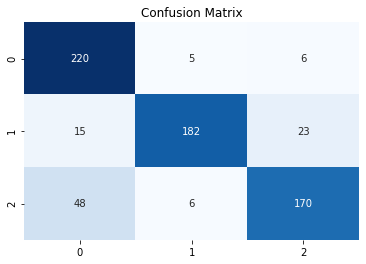

In [19]:
plt.title("Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,cmap="Blues",fmt="g",cbar=False)
plt.show()